In [1]:
%matplotlib inline

# to allow relative imports
import os
from sys_path_util import append_sys_path
append_sys_path()

from lib.experiments.utils.data_repo_api import DataRepoAPI

import pandas as pd
import matplotlib
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
import pickle
import datetime

from lib.configuration import DATA_REPO_URL_RAW

In [2]:
# https://censusreporter.org/profiles/05000US09009-new-haven-county-ct/
POPULATION = 854757
MAX_TIME = 200

In [3]:
def transform_covid(df):
    # transform dates
    df['Date updated'] = pd.to_datetime(df['Date updated'], format="%m/%d/%Y")
    df= df.sort_values('Date updated').reset_index(drop=True)

    col_transform = {
        'Total cases': 'float32',
        'Confirmed cases': 'float32',
        'Probable cases': 'float32',
        'Total case rate': 'float32',
        'Hospitalized cases': 'float32',
        'Total deaths': 'float32',
        'Confirmed deaths': 'float32',
        'Probable deaths': 'float32',
    }

    for c in col_transform:
        df[c] = df[c].apply(lambda x: x.replace(',', '') if type(x) == str else x, 1)

    df.replace('NaN', np.NaN, inplace=True)

    # transform numbers
    df = df.astype(col_transform)

    return df


def extract_new_haven(df):
    # filter new haven county (code = 5)
    df_out = df[df["County code"] == 5].copy()
    df_out.reset_index(drop=True, inplace=True)
    return df_out


def get_data_after_date(df, date: str, max_time=MAX_TIME):
    
    df = df[df['Date updated'] >= np.datetime64(date)].copy()
    df.reset_index(drop=True, inplace=True)
    
    start_date = df.loc[0, 'Date updated'].date()
    df['Date updated'] = df['Date updated'].apply(lambda x: (x.date() - start_date).days)
    
    df = df.loc[df['Date updated'] <= max_time, :].copy()
    
    return df


def tranform_case_counts(df):
    # first_val = df.loc[0, 'Total cases']
    first_val = 0
    new_cases = df['Total cases'].diff().fillna(first_val).values.tolist()

    df['New cases'] = new_cases
    
    return df.copy()


def make_new_haven_covid(start_date, max_time=MAX_TIME):
    
    covid = DataRepoAPI.get_csv('covid_by_county.csv')
    df = transform_covid(covid)
    df_new_haven = extract_new_haven(df)
    df_new_haven = get_data_after_date(df_new_haven, start_date, max_time)
    df_new_haven = tranform_case_counts(df_new_haven)
    
    return df_new_haven

## Modelled

In [11]:
def get_df(name):
    url = DATA_REPO_URL_RAW + '/validation/' + name + '.pkl'

    with urlopen(url) as f:
        df = pickle.load(f)

    return df


def df_group_mean(df):
    grouped = df.groupby(['time', 'compartment']).mean()
    grouped.reset_index(inplace=True)
    return grouped


def get_wide(name, max_time):
    
    # get data frame
    df = get_df(name)
    
    # transform
    df = df[df.time <= max_time]
    grouped = df_group_mean(df)
    wide = grouped.pivot(index=['time'], columns=['compartment'], values='value')
    wide.reset_index(inplace=True)
    
    # calc new cases
    # first_val = (-1) * (wide.loc[0, 'E'] + wide.loc[0, 'I'])
    first_val = 0
    new_cases = (wide['S'].diff().fillna(first_val) * (-1)).values.tolist()
    wide['New cases'] = new_cases
    
    # calc total cases
    # wide['Total cases'] = wide['New cases'].cumsum()
    wide['Total cases'] = wide['E'] + wide['I'] + wide['R']
    
    return wide

# ===========================

def model_tc(name, max_time=MAX_TIME):
    wide = get_wide(name, max_time)
    x = wide['time'].values.tolist()
    y = [c for c in wide['Total cases'].values.tolist()]
    return x, y


def model_nc(name, max_time=MAX_TIME):
    wide = get_wide(name, max_time)
    x = wide['time'].values.tolist()
    y = wide['New cases'].values.tolist()
    return x, y


def model_nc_smooth(name, max_time=MAX_TIME, p=7):
    wide = get_wide(name, max_time)
    x = wide['time'].values.tolist()
    y = [c for c in wide['New cases'].rolling(p).mean().values.tolist()]
    return x, y

# ===========================

def empirical_tc(df):
    x = df['Date updated'].values.tolist()
    y = [c / POPULATION for c in df['Total cases'].values.tolist()]
    return x, y


def empirical_nc(df):
    x = df['Date updated'].values.tolist()
    y = [c / POPULATION for c in df['New cases'].values.tolist()]
    return x, y


def empirical_nc_smooth(df, p=7):
    x = df['Date updated'].values.tolist()
    y = [c / POPULATION for c in df['New cases'].rolling(p).mean().values.tolist()]
    return x, y

In [12]:
wide = get_wide('seir_mobility_pre_validation', 200)
wide.head(10)

compartment,time,E,I,R,S,New cases,Total cases
0,0.0,0.01040,0.00000,0.00000,1.01118,-0.00000,0.01040
1,1.0,0.00934,0.00203,0.00008,1.01013,0.00105,0.01145
2,2.0,0.00883,0.00352,0.00027,1.00896,0.00117,0.01262
3,3.0,0.00862,0.00483,0.00070,1.00743,0.00153,0.01415
4,4.0,0.00909,0.00578,0.00132,1.00539,0.00204,0.01619
5,5.0,0.00929,0.00699,0.00191,1.00339,0.00200,0.01819
6,6.0,0.01001,0.00809,0.00260,1.00088,0.00251,0.02070
7,7.0,0.01101,0.00922,0.00350,0.99785,0.00303,0.02373
8,8.0,0.01207,0.01061,0.00440,0.99450,0.00335,0.02708
9,9.0,0.01375,0.01206,0.00548,0.99029,0.00421,0.03129


## Comparison

In [13]:
first_wave = make_new_haven_covid(start_date='2020-03-15')
second_wave = make_new_haven_covid(start_date='2020-11-01')

In [14]:
def comparison_plot(wave_df, model_func, empirical_func):
    matplotlib.style.use('seaborn')
    matplotlib.rcParams['figure.dpi'] = 300
    seaborn.set_context('notebook', font_scale=1.5)

    fig, (r1, r2) = plt.subplots(2, 3, figsize=(15, 8), facecolor='w', 
                                 gridspec_kw={'width_ratios': [1, 1, 1]})

    x, y = empirical_func(wave_df)

    data = [
        {'name': 'seir_mobility_pre_validation', 'title': 'Mobility (Pre)'},
        {'name': 'seir_plc_pre_validation', 'title': 'PLC (Pre)'},
        {'name': 'seir_distanced_pre_validation', 'title': 'Distanced (Pre)'},

        {'name': 'seir_mobility_post_validation', 'title': 'Mobility (Post)'},
        {'name': 'seir_plc_post_validation', 'title': 'PLC (Post)'},
        {'name': 'seir_distanced_post_validation', 'title': 'Distanced (Post)'},
    ]

    for ax, d in zip([*r1, *r2], data):
        ax.plot(*model_func(d['name'], MAX_TIME), color='steelblue')
        ax.plot(x, y, color='firebrick')
        ax.set_facecolor('#F5F5F5')
        ax.set_title(d['title'], fontsize=20)
        # ax.set_yscale('log')

    plt.subplots_adjust(hspace=0.5)
    # plt.savefig(GRAPHICS + '/comparison-network-metrics.png', bbox_inches="tight")
    plt.show()

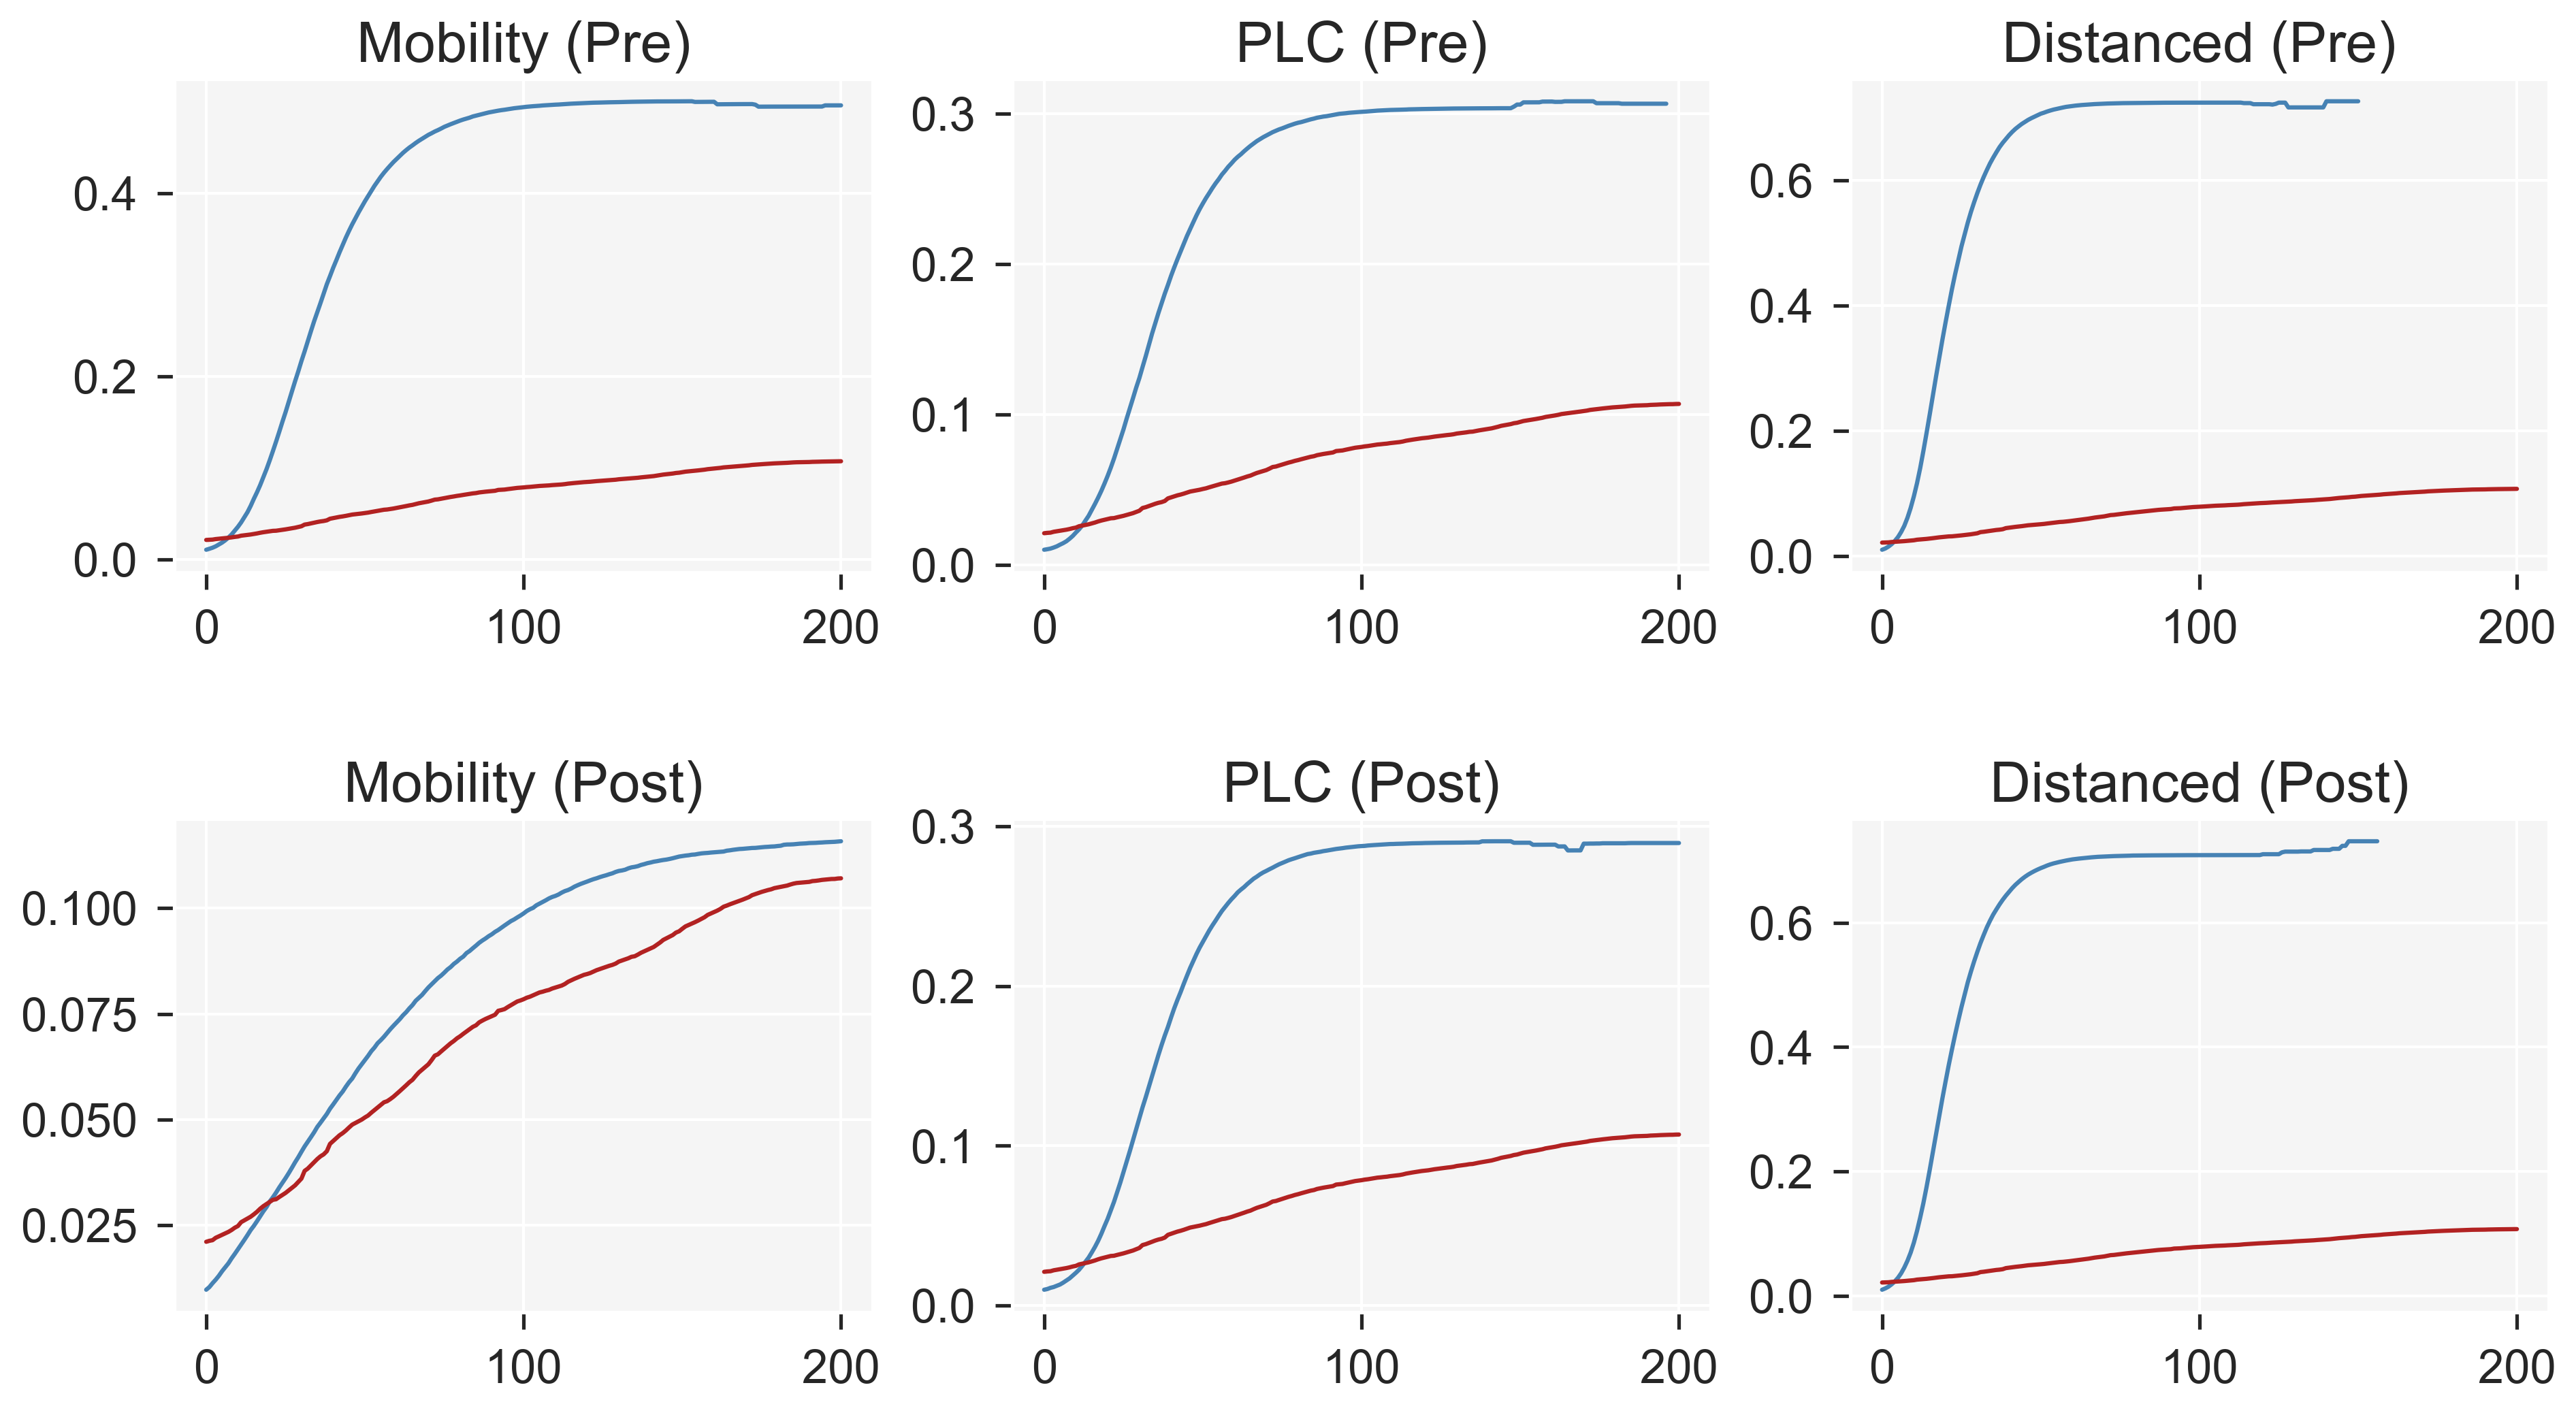

In [15]:
comparison_plot(second_wave, model_tc, empirical_tc)

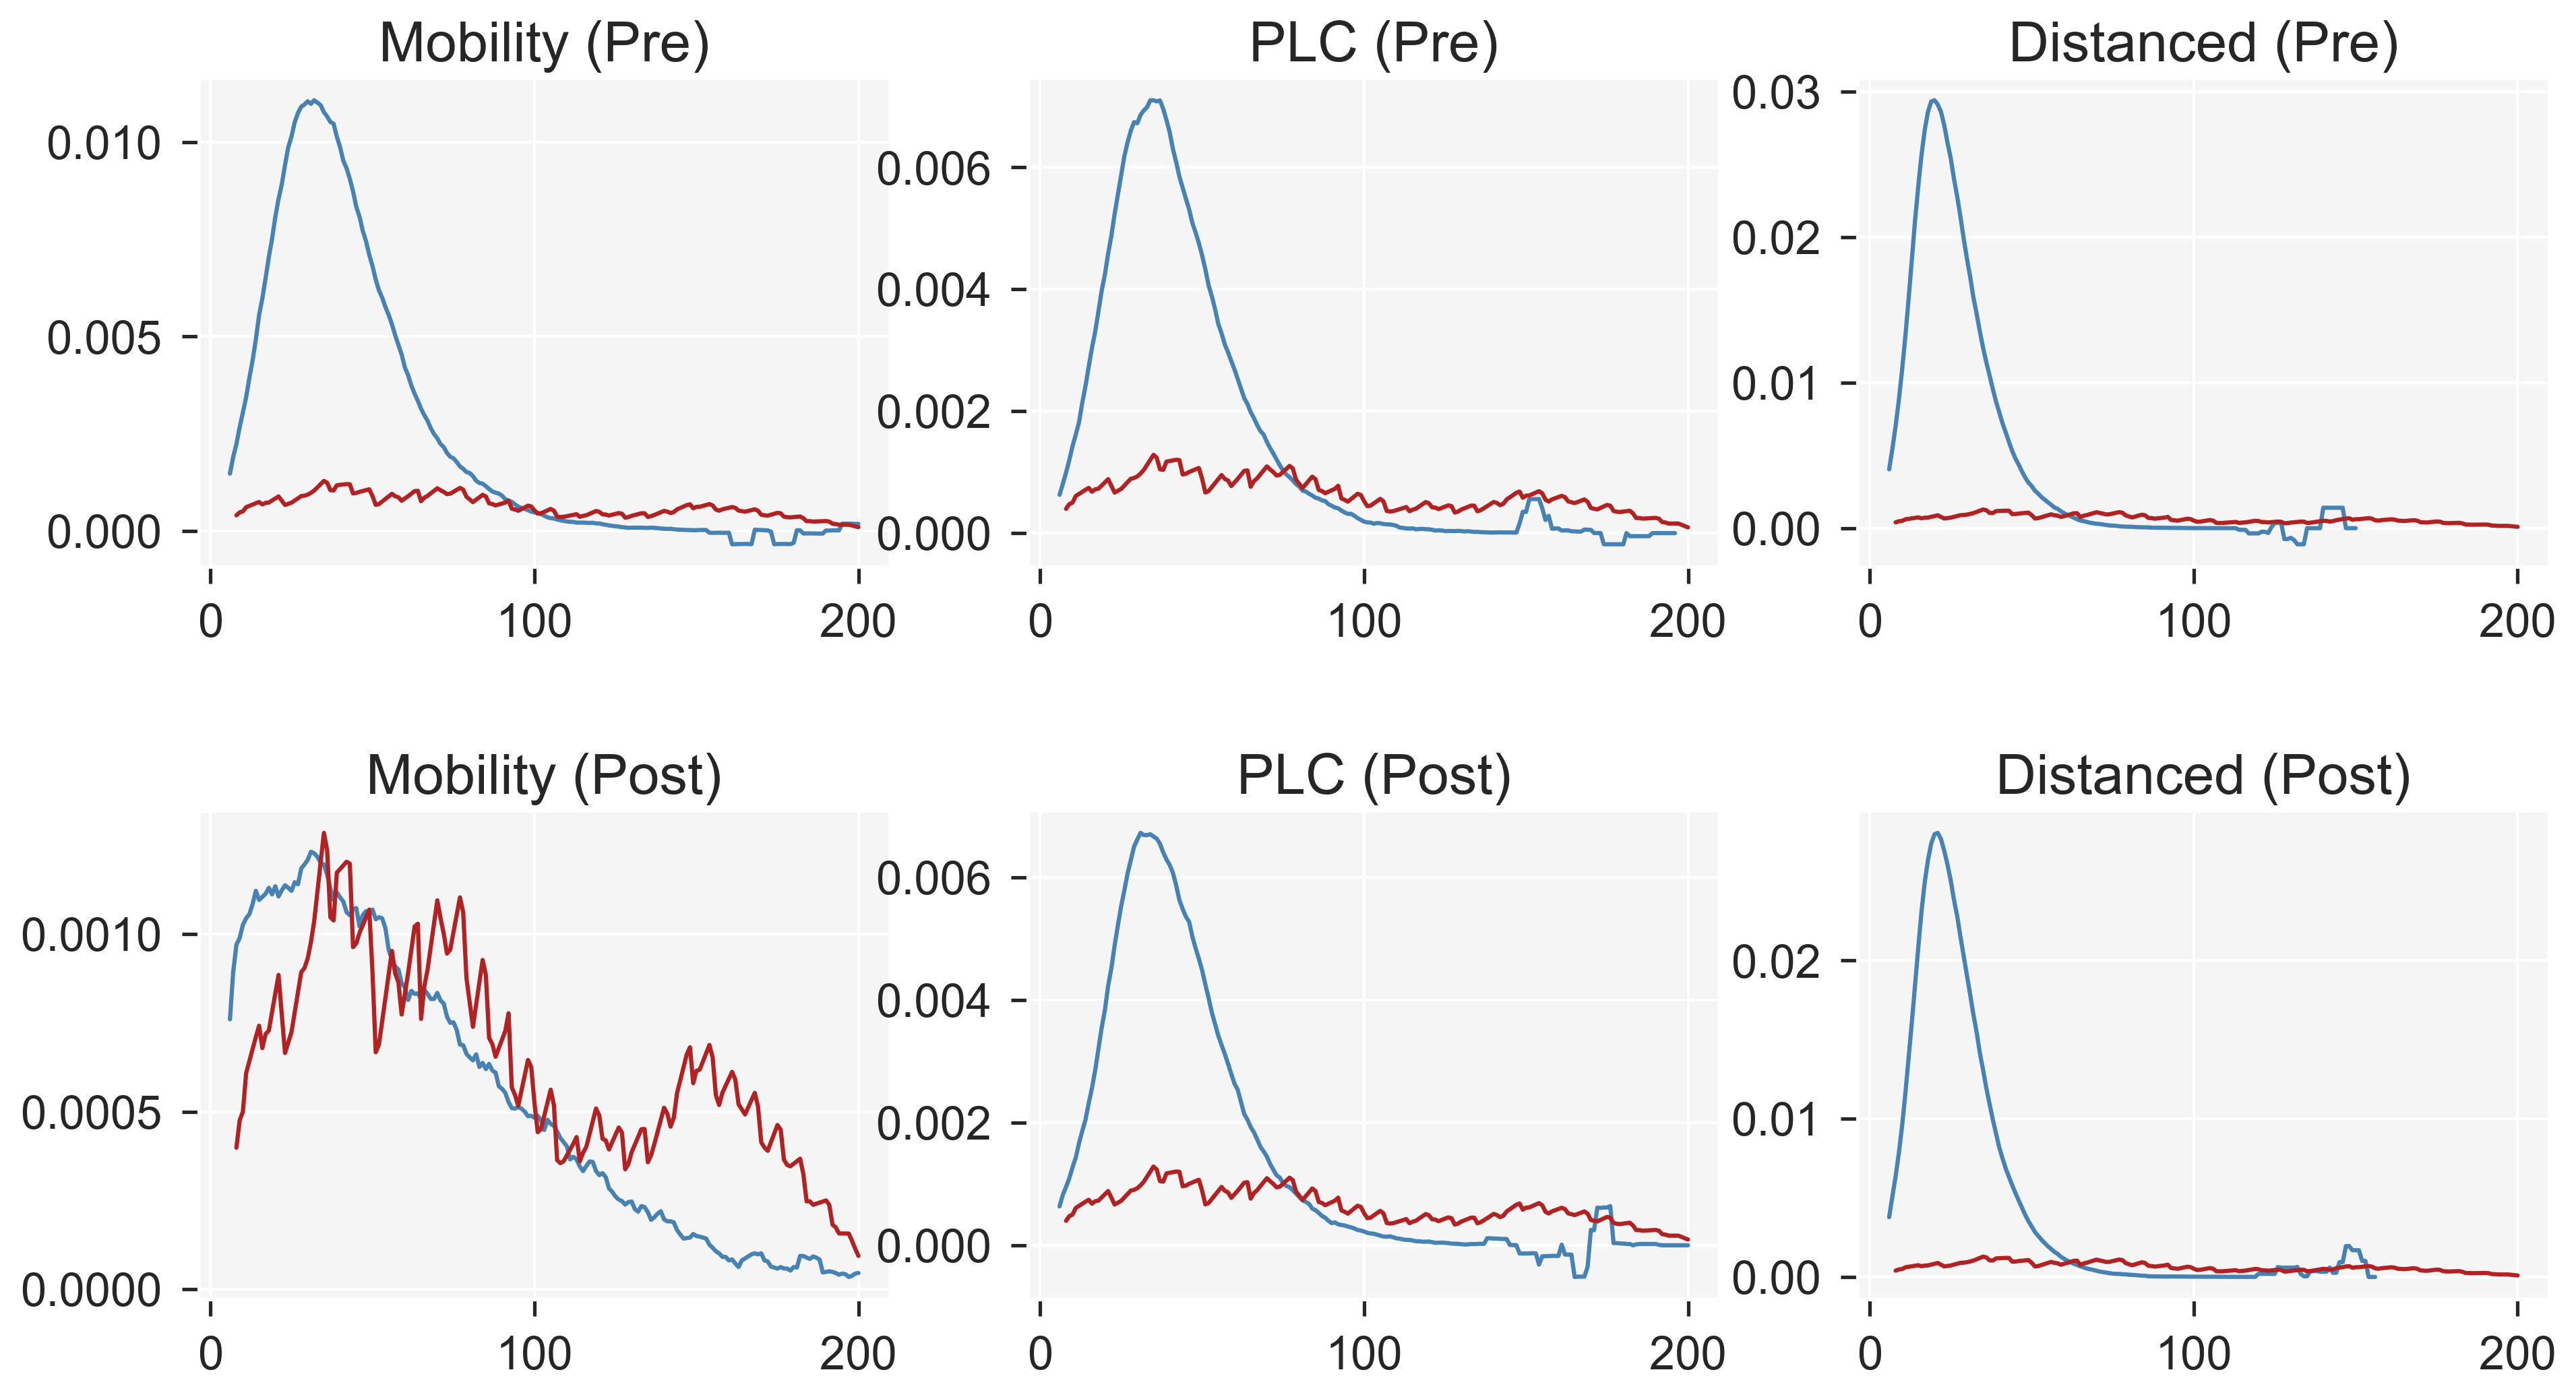

In [16]:
comparison_plot(second_wave, model_nc_smooth, empirical_nc_smooth)

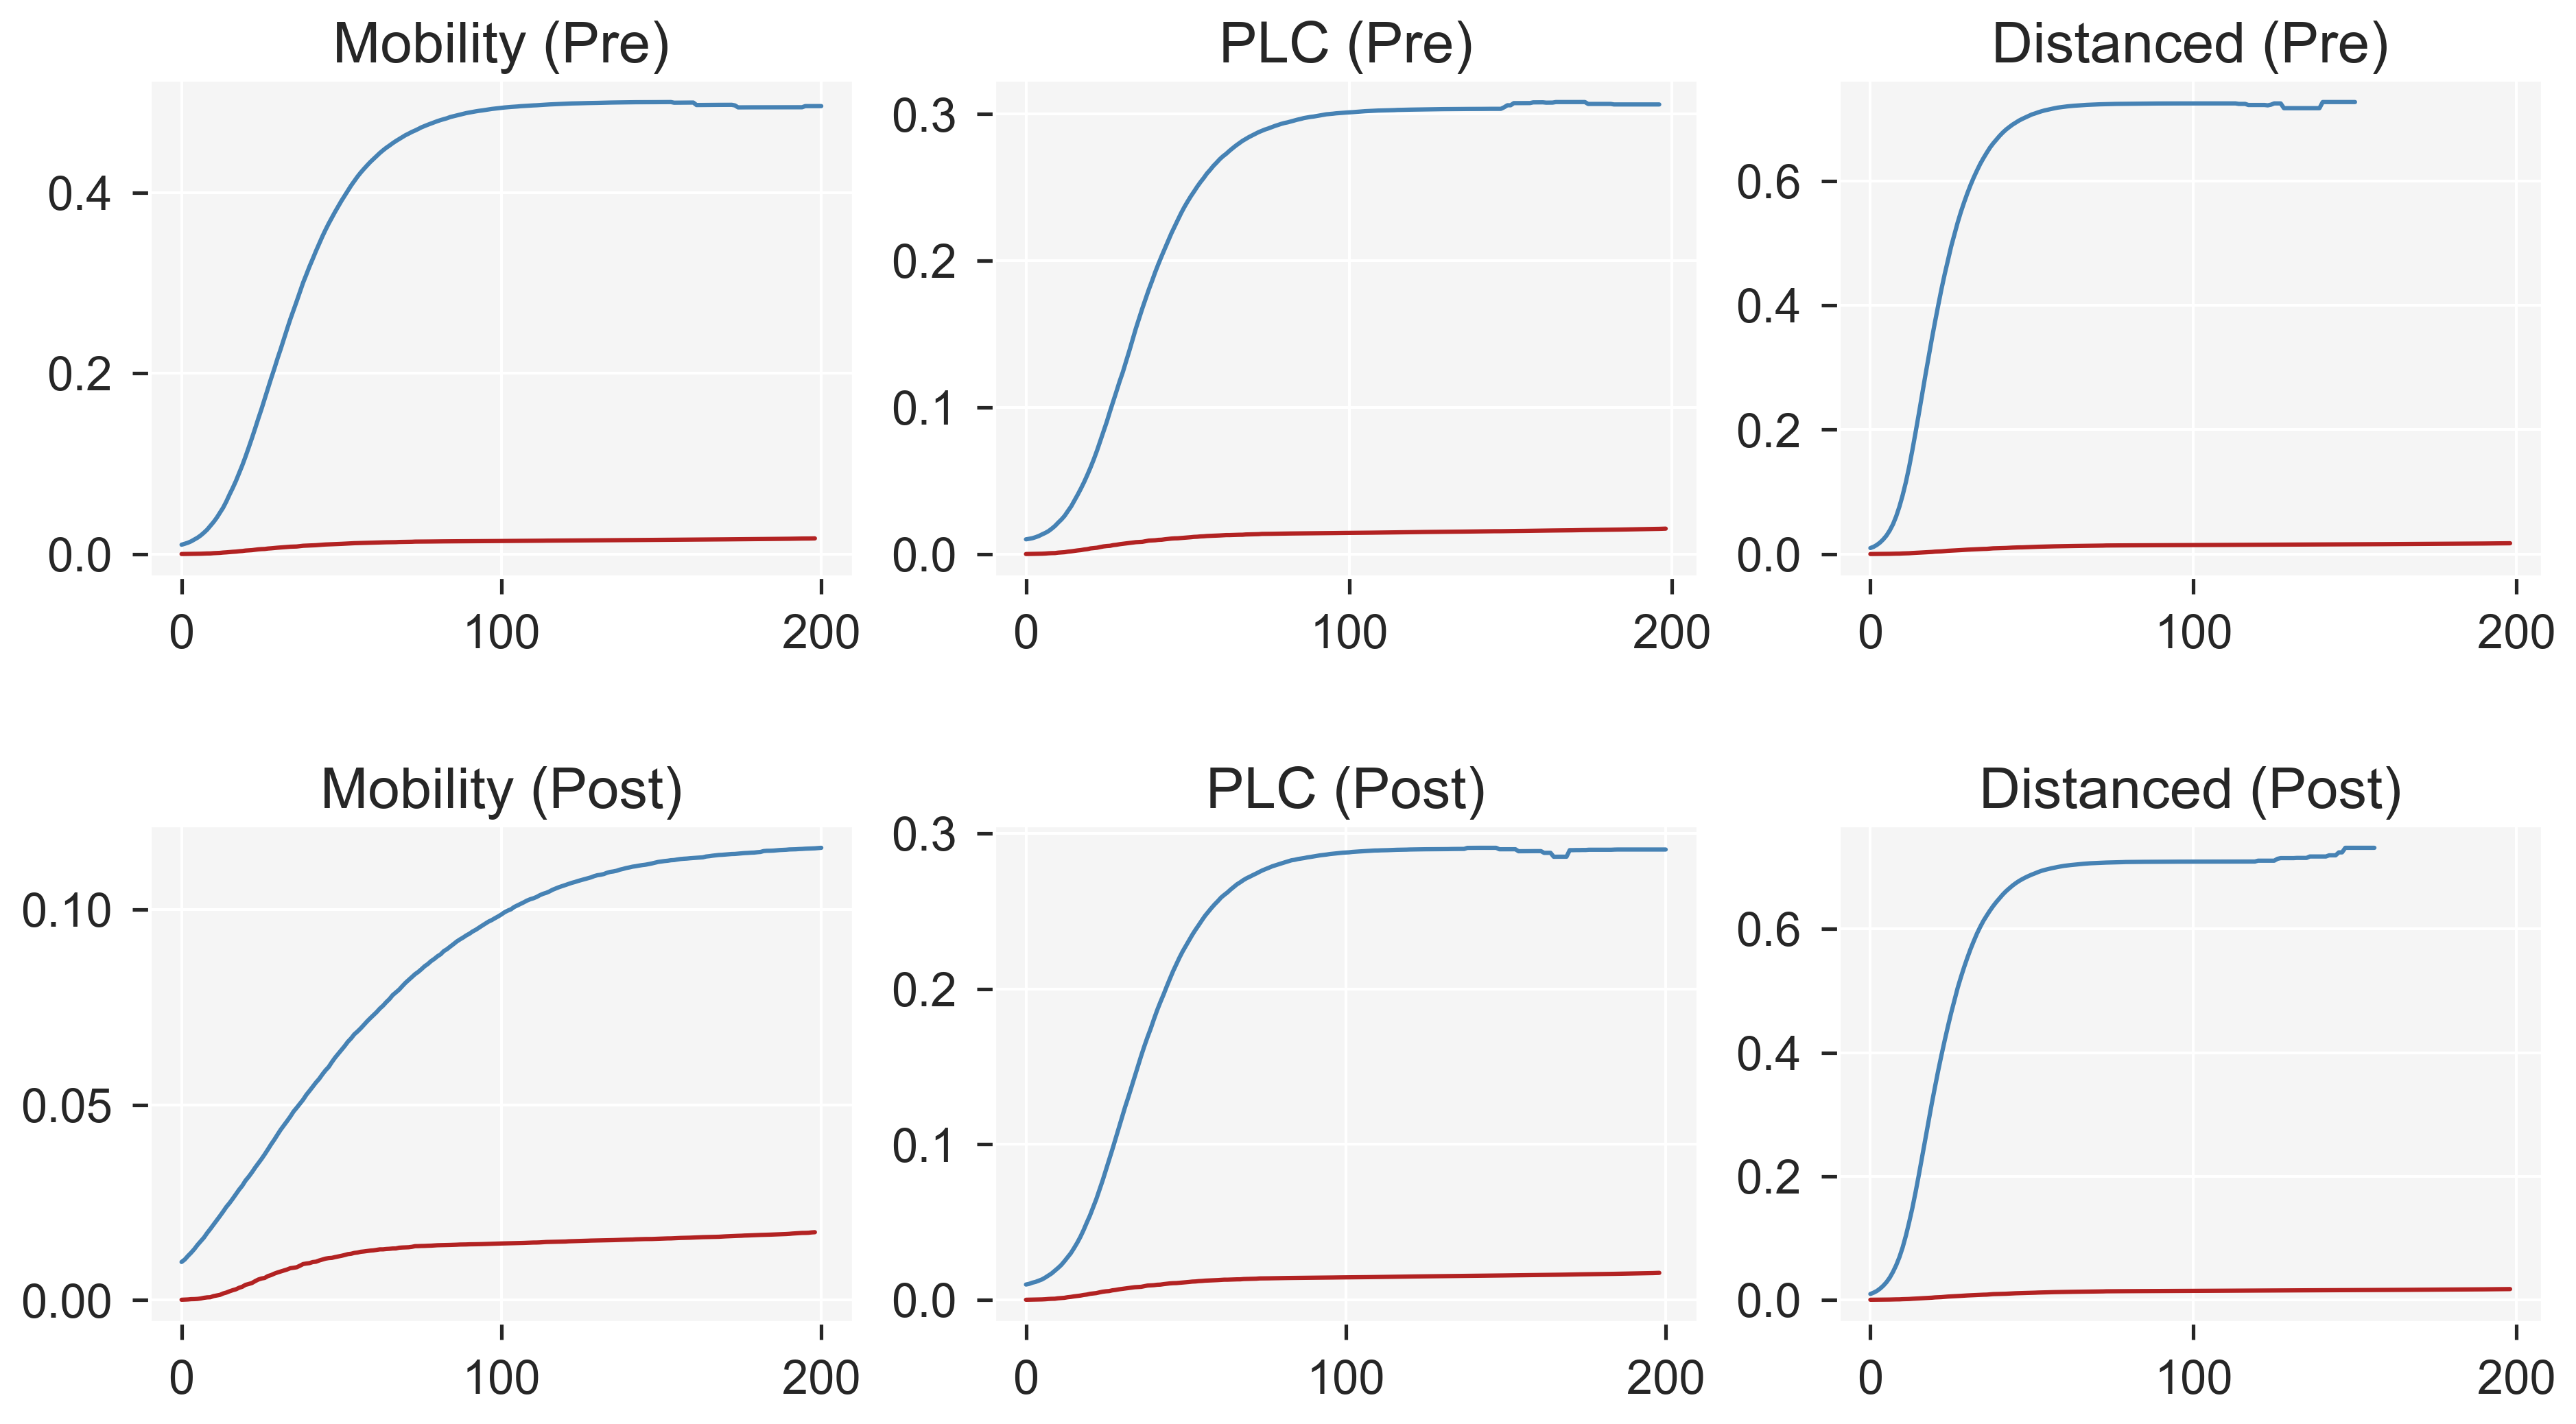

In [17]:
comparison_plot(first_wave, model_tc, empirical_tc)

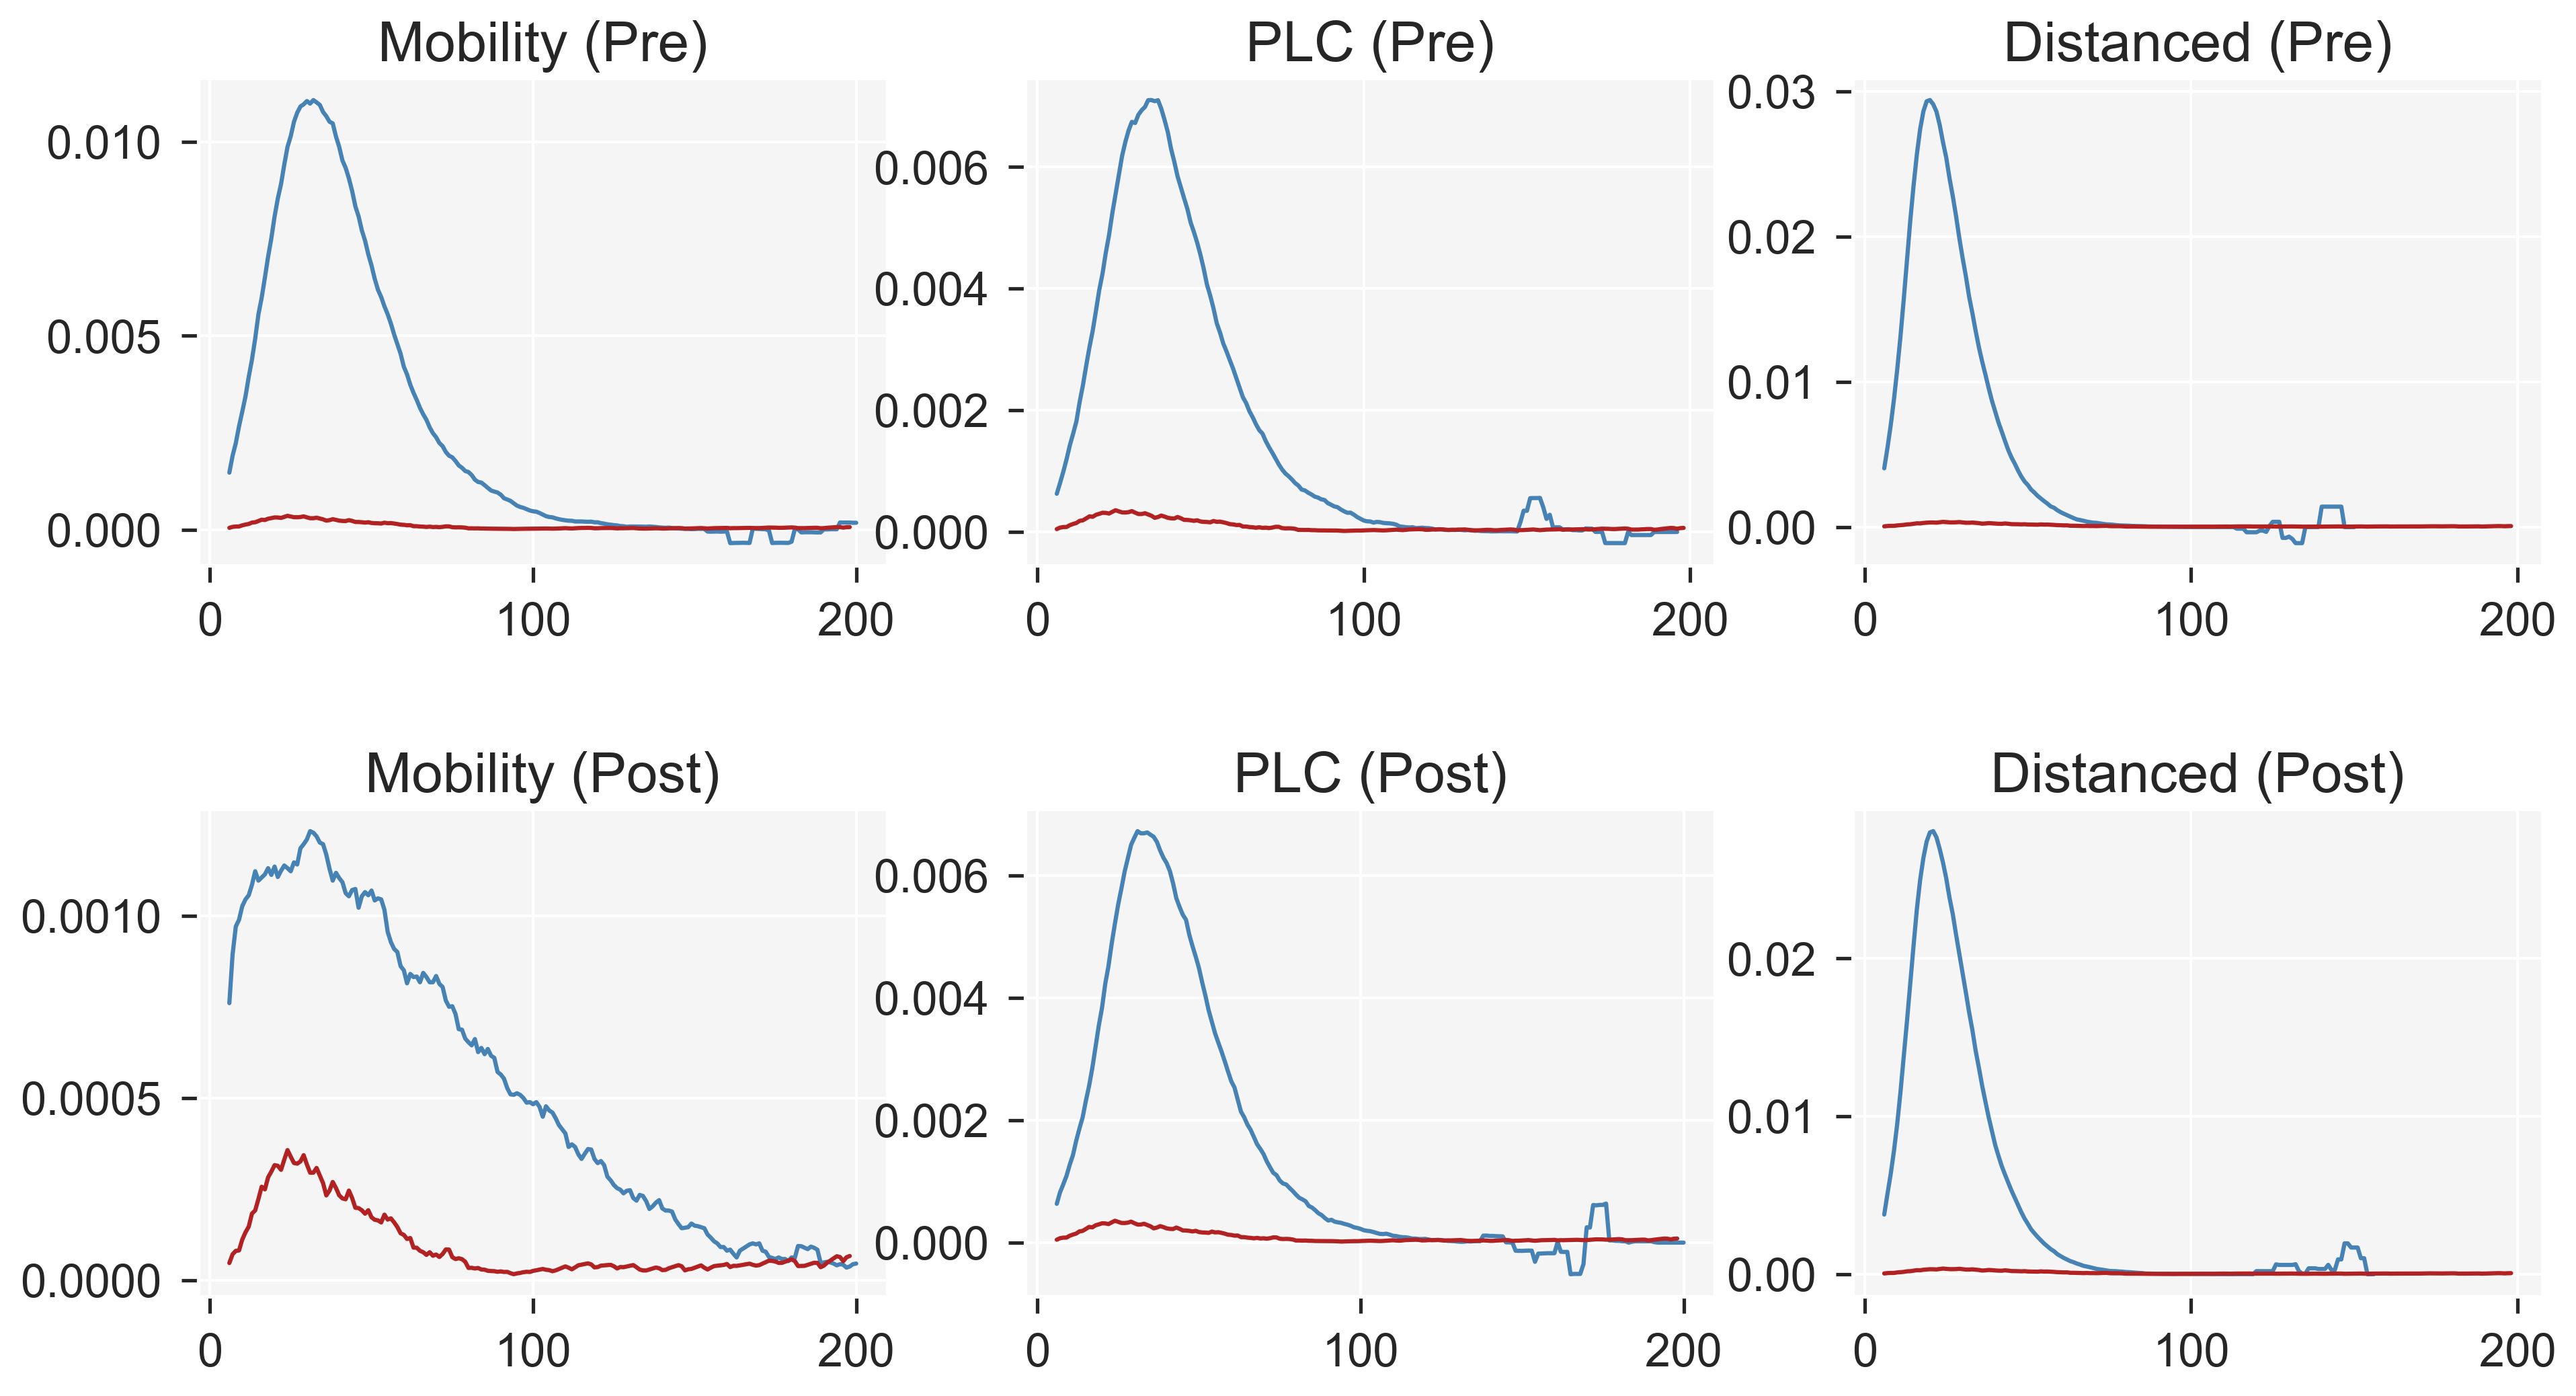

In [18]:
comparison_plot(first_wave, model_nc_smooth, empirical_nc_smooth)